# Chapter 9: Classification and Regression Trees

> (c) 2019 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> Code included in
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.

## Import required packages

In [1]:
%matplotlib inline

from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import matplotlib.pylab as plt
import dmba
from dmba import plotDecisionTree, classificationSummary, regressionSummary


## Figure 9.7

In [2]:
Delay_df = dmba.load_data('FlightDelays.csv')

In [3]:
Delay_df.head()

CRS_DEP_TIME CARRIER  DEP_TIME DEST  DISTANCE     FL_DATE  FL_NUM ORIGIN  \
0          1455      OH      1455  JFK       184  01/01/2004    5935    BWI   
1          1640      DH      1640  JFK       213  01/01/2004    6155    DCA   
2          1245      DH      1245  LGA       229  01/01/2004    7208    IAD   
3          1715      DH      1709  LGA       229  01/01/2004    7215    IAD   
4          1039      DH      1035  LGA       229  01/01/2004    7792    IAD   

   Weather  DAY_WEEK  DAY_OF_MONTH TAIL_NUM Flight Status  
0        0         4             1   N940CA        ontime  
1        0         4             1   N405FJ        ontime  
2        0         4             1   N695BR        ontime  
3        0         4             1   N662BR        ontime  
4        0         4             1   N698BR        ontime

In [4]:
Delay_df = Delay_df.drop('DAY_OF_MONTH', axis=1)

In [5]:
Delay_df.head()

CRS_DEP_TIME CARRIER  DEP_TIME DEST  DISTANCE     FL_DATE  FL_NUM ORIGIN  \
0          1455      OH      1455  JFK       184  01/01/2004    5935    BWI   
1          1640      DH      1640  JFK       213  01/01/2004    6155    DCA   
2          1245      DH      1245  LGA       229  01/01/2004    7208    IAD   
3          1715      DH      1709  LGA       229  01/01/2004    7215    IAD   
4          1039      DH      1035  LGA       229  01/01/2004    7792    IAD   

   Weather  DAY_WEEK TAIL_NUM Flight Status  
0        0         4   N940CA        ontime  
1        0         4   N405FJ        ontime  
2        0         4   N695BR        ontime  
3        0         4   N662BR        ontime  
4        0         4   N698BR        ontime

In [6]:
# Delay_df['CARRIER'] = Delay_df['CARRIER'].astype('category') # 범주형으로 변환
Delay_df_encoded = pd.get_dummies(Delay_df, columns=['CARRIER', 'DEST', 'ORIGIN']) # 범주값을 이진변수로


In [7]:
Delay_df_encoded['FL_DATE'] = pd.to_datetime(Delay_df_encoded['FL_DATE'])
Delay_df_encoded['Day'] = Delay_df_encoded['FL_DATE'].dt.day

In [8]:
Delay_df_encoded.head()

CRS_DEP_TIME  DEP_TIME  DISTANCE    FL_DATE  FL_NUM  Weather  DAY_WEEK  \
0          1455      1455       184 2004-01-01    5935        0         4   
1          1640      1640       213 2004-01-01    6155        0         4   
2          1245      1245       229 2004-01-01    7208        0         4   
3          1715      1709       229 2004-01-01    7215        0         4   
4          1039      1035       229 2004-01-01    7792        0         4   

  TAIL_NUM Flight Status  CARRIER_CO  ...  CARRIER_RU  CARRIER_UA  CARRIER_US  \
0   N940CA        ontime           0  ...           0           0           0   
1   N405FJ        ontime           0  ...           0           0           0   
2   N695BR        ontime           0  ...           0           0           0   
3   N662BR        ontime           0  ...           0           0           0   
4   N698BR        ontime           0  ...           0           0           0   

   DEST_EWR  DEST_JFK  DEST_LGA  ORIGIN_BWI  ORIGIN_DCA  ORIGIN_IAD  Day  
0         0         1         0           1           0           0    1  
1         0         1         0           0           1           0    1  
2         0         0         1           0           0           1    1  
3         0         0         1           0           0           1    1  
4         0         0         1           0           0           1    1  

[5 rows x 24 columns]

In [9]:
Delay_df_encoded = Delay_df_encoded.drop(['FL_DATE','TAIL_NUM'], axis=1)

In [10]:
Delay_df_encoded.head()

CRS_DEP_TIME  DEP_TIME  DISTANCE  FL_NUM  Weather  DAY_WEEK Flight Status  \
0          1455      1455       184    5935        0         4        ontime   
1          1640      1640       213    6155        0         4        ontime   
2          1245      1245       229    7208        0         4        ontime   
3          1715      1709       229    7215        0         4        ontime   
4          1039      1035       229    7792        0         4        ontime   

   CARRIER_CO  CARRIER_DH  CARRIER_DL  ...  CARRIER_RU  CARRIER_UA  \
0           0           0           0  ...           0           0   
1           0           1           0  ...           0           0   
2           0           1           0  ...           0           0   
3           0           1           0  ...           0           0   
4           0           1           0  ...           0           0   

   CARRIER_US  DEST_EWR  DEST_JFK  DEST_LGA  ORIGIN_BWI  ORIGIN_DCA  \
0           0         0         1         0           1           0   
1           0         0         1         0           0           1   
2           0         0         0         1           0           0   
3           0         0         0         1           0           0   
4           0         0         0         1           0           0   

   ORIGIN_IAD  Day  
0           0    1  
1           0    1  
2           1    1  
3           1    1  
4           1    1  

[5 rows x 22 columns]

In [11]:
# 'DAY_WEEK'가 숫자로 표현되어 있으나 범주형으로 변형해야함.
Delay_df_encoded['DAY_WEEK'] = Delay_df_encoded['DAY_WEEK'].astype('category')

In [12]:
# 출발시간 8구간으로 나누기
Delay_df_encoded['Bins_CRS'] = pd.cut(Delay_df_encoded['CRS_DEP_TIME'], bins=8)

# 구간의 중앙값을 실수로 변환
Delay_df_encoded['Bins_CRS'] = Delay_df_encoded['Bins_CRS'].apply(lambda x: x.mid)


In [13]:
Delay_df_encoded.head()

CRS_DEP_TIME  DEP_TIME  DISTANCE  FL_NUM  Weather DAY_WEEK Flight Status  \
0          1455      1455       184    5935        0        4        ontime   
1          1640      1640       213    6155        0        4        ontime   
2          1245      1245       229    7208        0        4        ontime   
3          1715      1709       229    7215        0        4        ontime   
4          1039      1035       229    7792        0        4        ontime   

   CARRIER_CO  CARRIER_DH  CARRIER_DL  ...  CARRIER_UA  CARRIER_US  DEST_EWR  \
0           0           0           0  ...           0           0         0   
1           0           1           0  ...           0           0         0   
2           0           1           0  ...           0           0         0   
3           0           1           0  ...           0           0         0   
4           0           1           0  ...           0           0         0   

   DEST_JFK  DEST_LGA  ORIGIN_BWI  ORIGIN_DCA  ORIGIN_IAD  Day  Bins_CRS  
0         1         0           1           0           0    1  1460.625  
1         1         0           0           1           0    1  1651.875  
2         0         1           0           0           1    1  1269.375  
3         0         1           0           0           1    1  1651.875  
4         0         1           0           0           1    1  1078.125  

[5 rows x 23 columns]

In [14]:
Delay_df_encoded['Delay'] = Delay_df_encoded['Flight Status'].apply(lambda x: '1' if x=='delayed' else '0')


In [15]:
Delay_df_encoded.head()

CRS_DEP_TIME  DEP_TIME  DISTANCE  FL_NUM  Weather DAY_WEEK Flight Status  \
0          1455      1455       184    5935        0        4        ontime   
1          1640      1640       213    6155        0        4        ontime   
2          1245      1245       229    7208        0        4        ontime   
3          1715      1709       229    7215        0        4        ontime   
4          1039      1035       229    7792        0        4        ontime   

   CARRIER_CO  CARRIER_DH  CARRIER_DL  ...  CARRIER_US  DEST_EWR  DEST_JFK  \
0           0           0           0  ...           0         0         1   
1           0           1           0  ...           0         0         1   
2           0           1           0  ...           0         0         0   
3           0           1           0  ...           0         0         0   
4           0           1           0  ...           0         0         0   

   DEST_LGA  ORIGIN_BWI  ORIGIN_DCA  ORIGIN_IAD  Day  Bins_CRS  Delay  
0         0           1           0           0    1  1460.625      0  
1         0           0           1           0    1  1651.875      0  
2         1           0           0           1    1  1269.375      0  
3         1           0           0           1    1  1651.875      0  
4         1           0           0           1    1  1078.125      0  

[5 rows x 24 columns]

In [16]:
Delay_df_encoded = Delay_df_encoded.drop(['Flight Status','CRS_DEP_TIME'], axis=1)

In [17]:
classTree = DecisionTreeClassifier(random_state=0, max_depth=8) # 최대 깊이 8
classTree.fit(Delay_df_encoded.drop(columns=['Delay']), Delay_df_encoded['Delay']) 

DecisionTreeClassifier(max_depth=8, random_state=0)

Classes: 0, 1


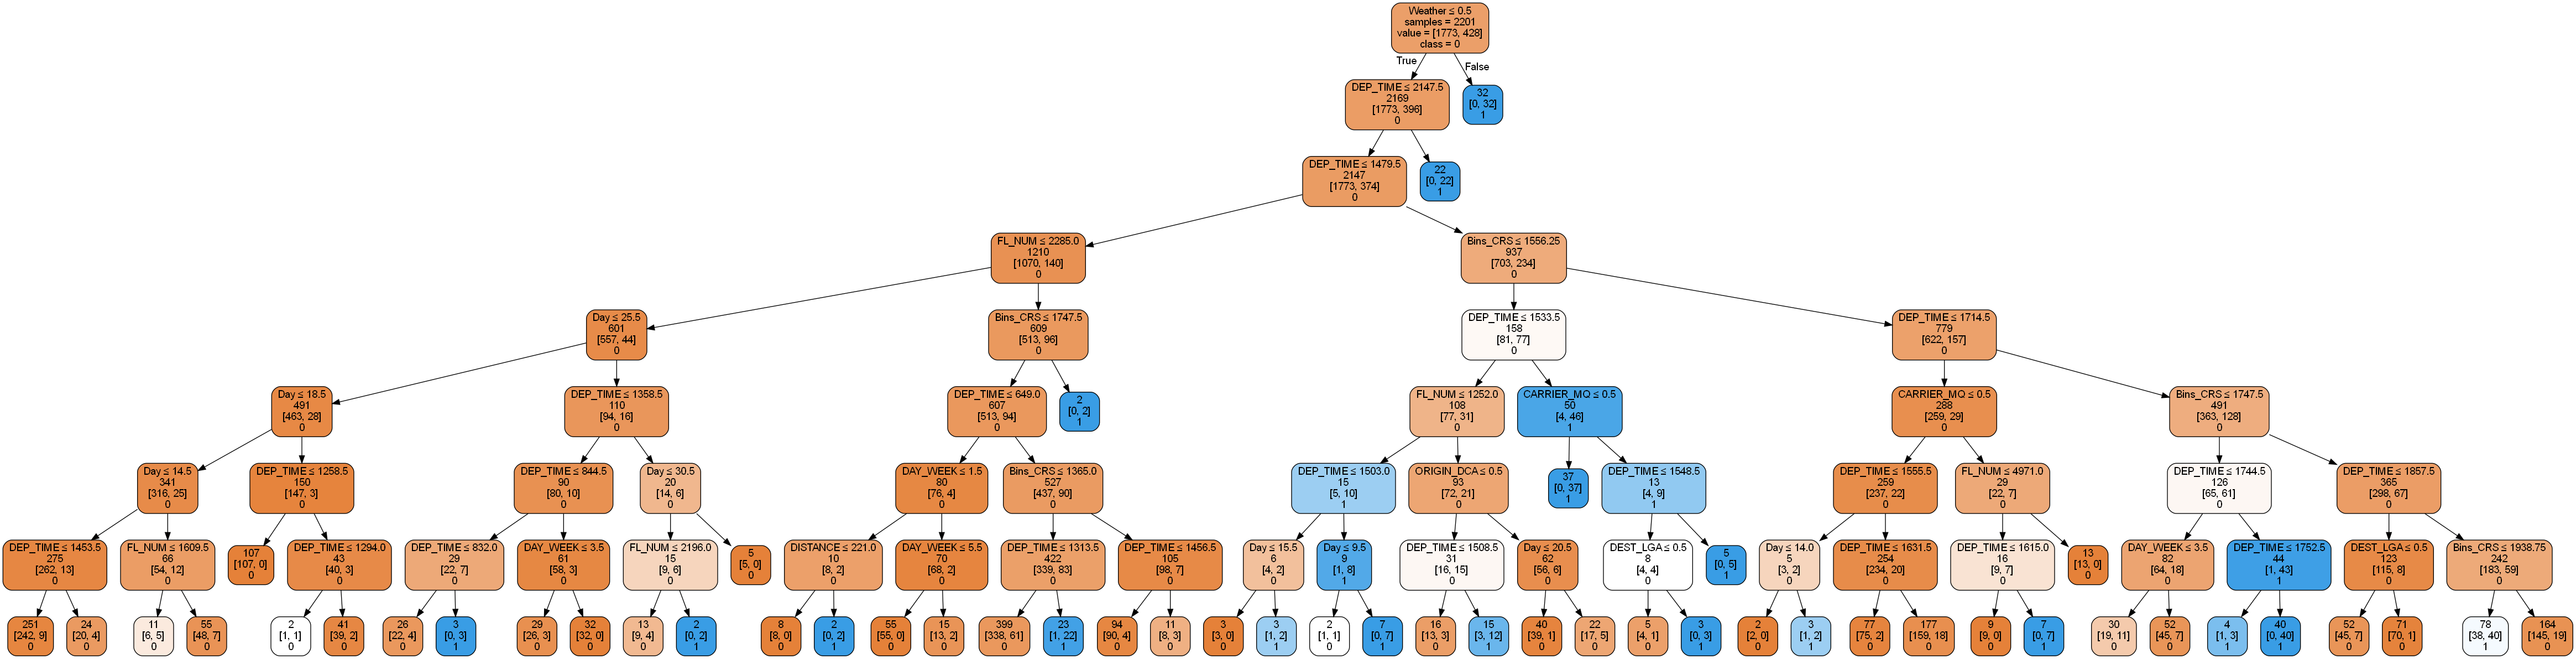

In [18]:
print("Classes: {}".format(', '.join(classTree.classes_)))
plotDecisionTree(classTree, feature_names=Delay_df_encoded.columns[:21], class_names=classTree.classes_)

The order of the `values` vector in the boxes is the same as `classTree.classes_`.

## Figure 9.10

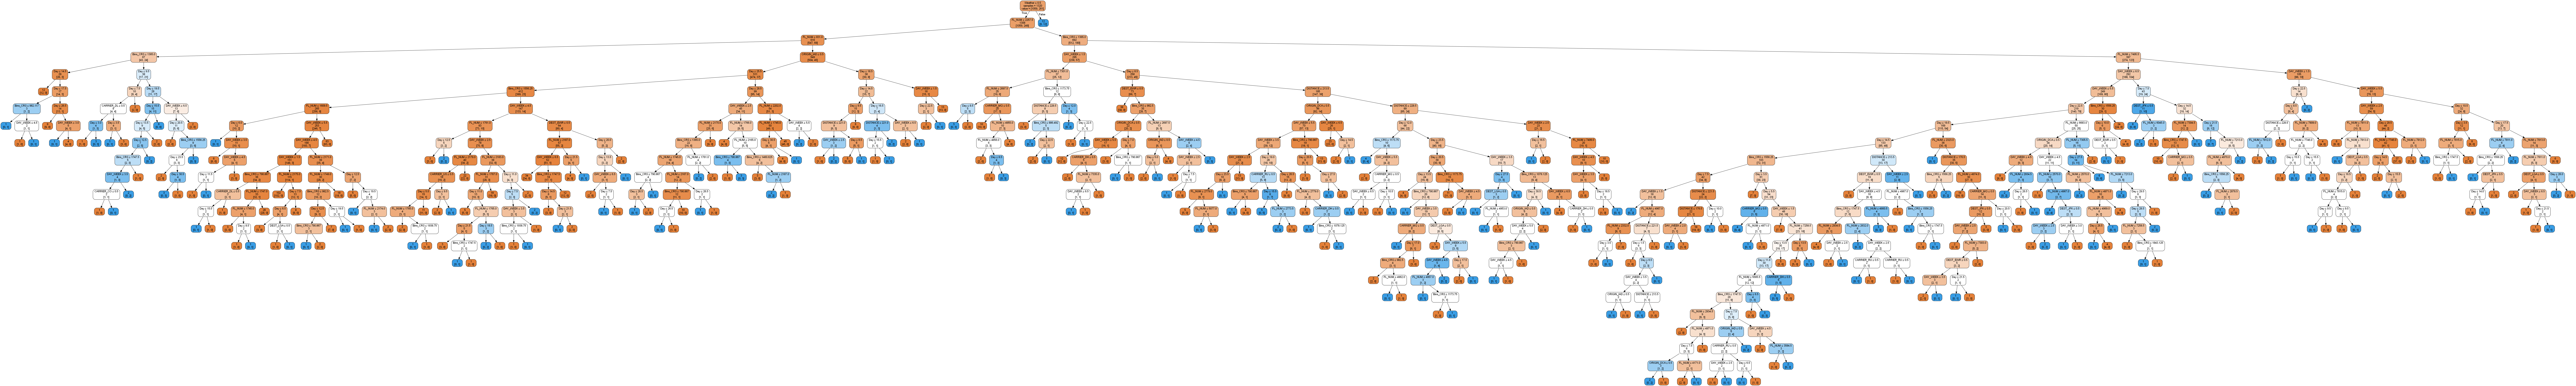

In [19]:
# bank_df = dmba.load_data('UniversalBank.csv')
# bank_df = bank_df.drop(columns=['ID', 'ZIP Code'])

X = Delay_df_encoded.drop(columns=['Delay','DEP_TIME'])
y = Delay_df_encoded['Delay']
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

fullClassTree = DecisionTreeClassifier()
fullClassTree.fit(train_X, train_y)

plotDecisionTree(fullClassTree, feature_names=train_X.columns)

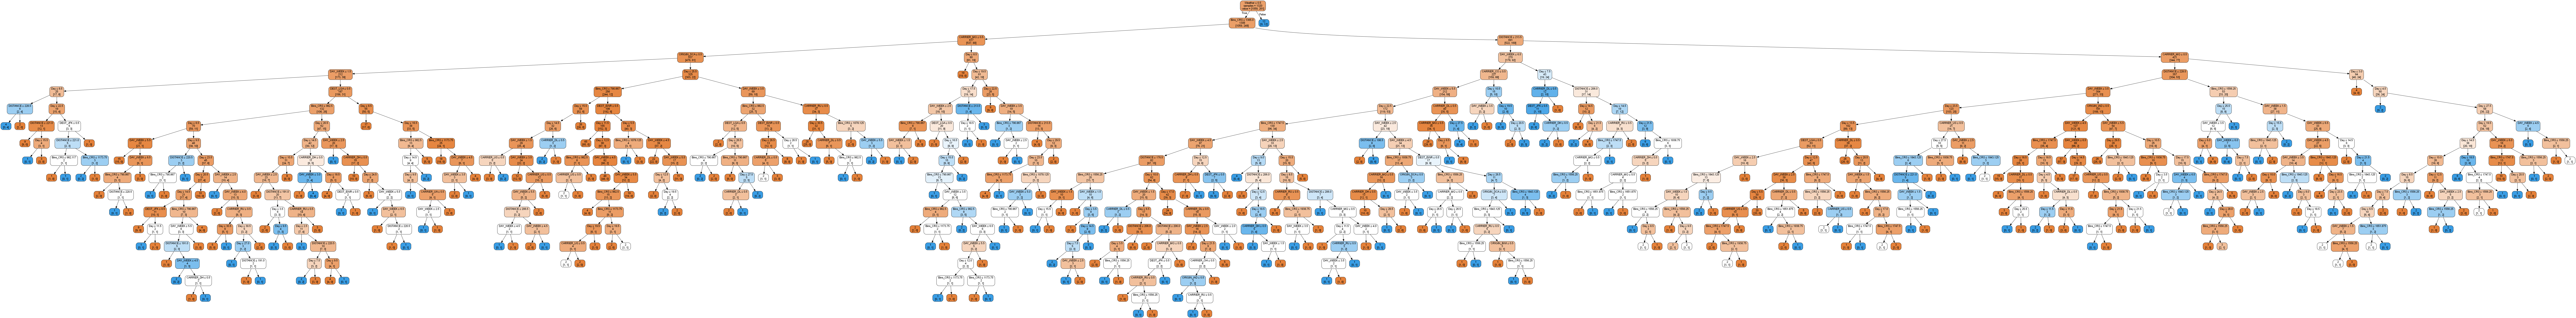

In [20]:
# bank_df = dmba.load_data('UniversalBank.csv')
# bank_df = bank_df.drop(columns=['ID', 'ZIP Code'])

X = Delay_df_encoded.drop(columns=['Delay','DEP_TIME','FL_NUM'])
y = Delay_df_encoded['Delay']
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

fullClassTree = DecisionTreeClassifier()
fullClassTree.fit(train_X, train_y)

plotDecisionTree(fullClassTree, feature_names=train_X.columns)

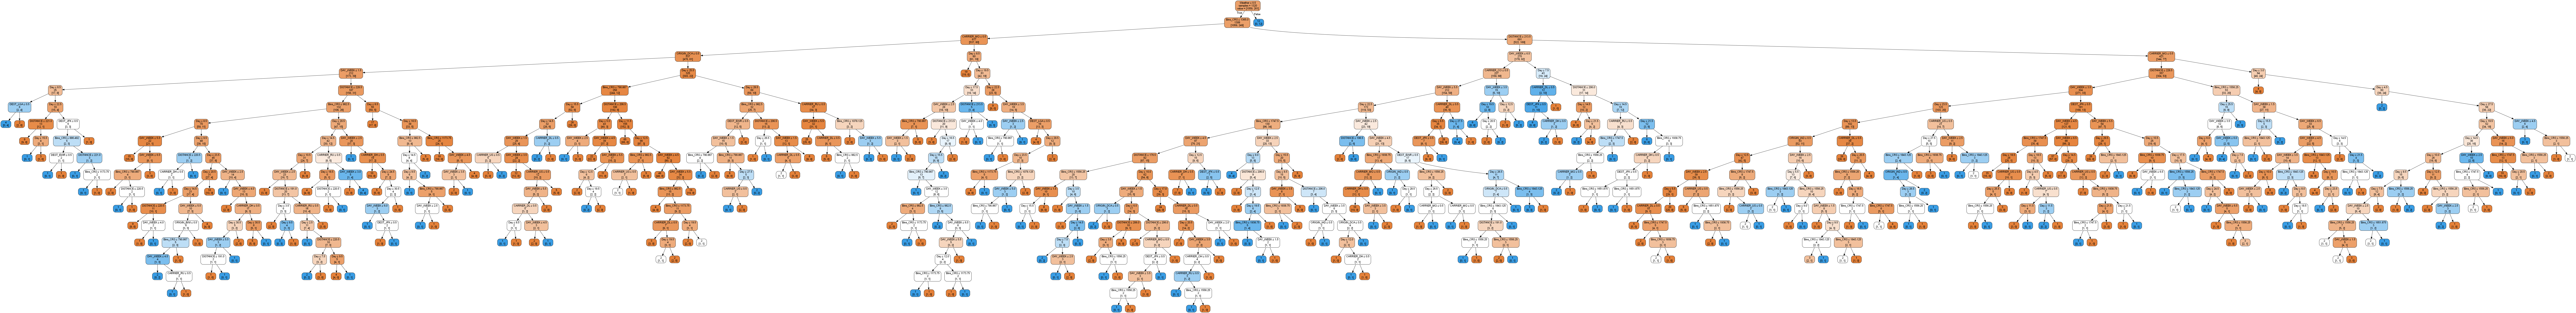

In [21]:
# bank_df = dmba.load_data('UniversalBank.csv')
# bank_df = bank_df.drop(columns=['ID', 'ZIP Code'])

X = Delay_df_encoded.drop(columns=['Delay','DEP_TIME','FL_NUM'])
y = Delay_df_encoded['Delay']
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

fullClassTree = DecisionTreeClassifier()
fullClassTree.fit(train_X, train_y)

plotDecisionTree(fullClassTree, feature_names=train_X.columns)

## Table 9.3
<!-- <div class='alert alert-danger'>R output for reference - remove once missing metrics are available.
```
> confusionMatrix(default.ct.point.pred.train, train.df$Personal.Loan)
Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 2696   26
         1   13  265
                                          
               Accuracy : 0.987           
                 95% CI : (0.9823, 0.9907)
    No Information Rate : 0.903           
    P-Value [Acc > NIR] : < 2e-16         
                                          
                  Kappa : 0.9243          
 Mcnemar's Test P-Value : 0.05466         
                                          
            Sensitivity : 0.9952          
            Specificity : 0.9107          
         Pos Pred Value : 0.9904          
         Neg Pred Value : 0.9532          
             Prevalence : 0.9030          
         Detection Rate : 0.8987          
   Detection Prevalence : 0.9073          
      Balanced Accuracy : 0.9529          
                                          
       'Positive' Class : 0               
```
</div>-->

In [22]:
classificationSummary(train_y, fullClassTree.predict(train_X))
classificationSummary(valid_y, fullClassTree.predict(valid_X))

Confusion Matrix (Accuracy 0.9864)

       Prediction
Actual    0    1
     0 1059    0
     1   18  243
Confusion Matrix (Accuracy 0.7673)

       Prediction
Actual   0   1
     0 588 126
     1  79  88


## Table 9.4

In [23]:
# Five-fold cross-validation of the full decision tree classifier
treeClassifier = DecisionTreeClassifier()

scores = cross_val_score(treeClassifier, train_X, train_y, cv=5)
print('Accuracy scores of each fold: ', [f'{acc:.3f}' for acc in scores])
print(f'Accuracy: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})')
print(f'Accuracy: {scores.mean():.3f} (+/- {scores.std():.3f})')

Accuracy scores of each fold:  ['0.761', '0.788', '0.765', '0.750', '0.727']
Accuracy: 0.758 (+/- 0.040)
Accuracy: 0.758 (+/- 0.020)


## Figure 9.12

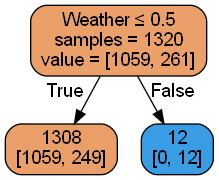

In [24]:
smallClassTree = DecisionTreeClassifier(max_depth=30, min_samples_split=20, min_impurity_decrease=0.01)
smallClassTree.fit(train_X, train_y)

plotDecisionTree(smallClassTree, feature_names=train_X.columns)

## Table 9.5

In [25]:
classificationSummary(train_y, smallClassTree.predict(train_X))
classificationSummary(valid_y, smallClassTree.predict(valid_X))

Confusion Matrix (Accuracy 0.8114)

       Prediction
Actual    0    1
     0 1059    0
     1  249   12
Confusion Matrix (Accuracy 0.8331)

       Prediction
Actual   0   1
     0 714   0
     1 147  20


## Grid search

## Table 9.6

In [26]:
# Start with an initial guess for parameters
param_grid = {
    'max_depth': [10, 20, 30, 40], 
    'min_samples_split': [20, 40, 60, 80, 100], 
    'min_impurity_decrease': [0, 0.0005, 0.001, 0.005, 0.01], 
}
gridSearch = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Initial score: ', gridSearch.best_score_)
print('Initial parameters: ', gridSearch.best_params_)

# Adapt grid based on result from initial grid search
param_grid = {
    'max_depth': list(range(2, 16)), 
    'min_samples_split': list(range(10, 22)), 
    'min_impurity_decrease': [0.0009, 0.001, 0.0011], 
}
gridSearch = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Improved score: ', gridSearch.best_score_)
print('Improved parameters: ', gridSearch.best_params_)

bestClassTree = gridSearch.best_estimator_

Initial score:  0.8075757575757574
Initial parameters:  {'max_depth': 10, 'min_impurity_decrease': 0.01, 'min_samples_split': 20}
Improved score:  0.8083333333333332
Improved parameters:  {'max_depth': 2, 'min_impurity_decrease': 0.0009, 'min_samples_split': 10}


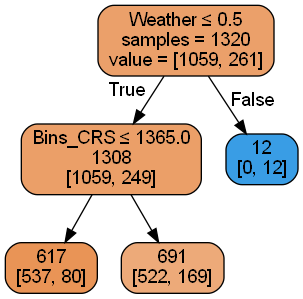

In [27]:
plotDecisionTree(bestClassTree, feature_names=train_X.columns)

In [28]:
classificationSummary(train_y, bestClassTree.predict(train_X))
classificationSummary(valid_y, bestClassTree.predict(valid_X))

Confusion Matrix (Accuracy 0.8114)

       Prediction
Actual    0    1
     0 1059    0
     1  249   12
Confusion Matrix (Accuracy 0.8331)

       Prediction
Actual   0   1
     0 714   0
     1 147  20


## Figure 9.16

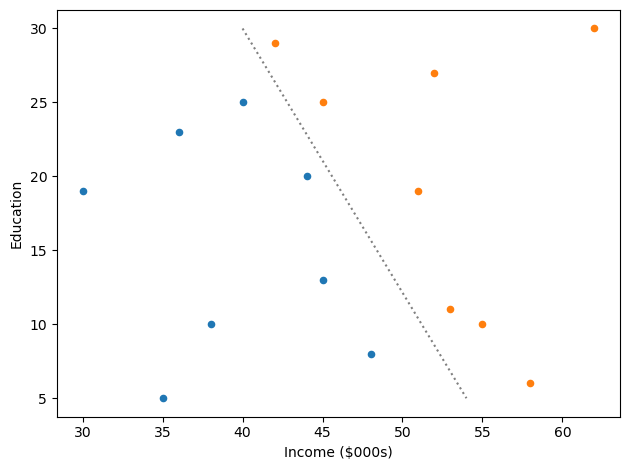

In [29]:
fakeScatter = pd.DataFrame([
    (30, 19, 1), (35, 5, 1), (40, 25, 1), (45, 13, 1), 
    (38, 10, 1), (36, 23, 1), (48, 8, 1), (44, 20, 1), (50, 12),
    (51, 19, 0), (62, 30, 0), (42, 29, 0), (45, 25, 0), 
    (55, 10, 0), (52, 27, 0), (58, 6, 0), (53, 11, 0), 
], columns=['x', 'y', 'category'])
ax = fakeScatter.loc[fakeScatter.category==1,:].plot.scatter(x='x', y='y', color='C0')
fakeScatter.loc[fakeScatter.category==0,:].plot.scatter(x='x', y='y', ax=ax, color='C1')
plt.plot((40, 54), (30, 5), ':', color='grey')
ax.set_xlabel('Income ($000s)')
ax.set_ylabel('Education')

plt.tight_layout()
plt.show()

NameError: name 'mower_df' is not defined

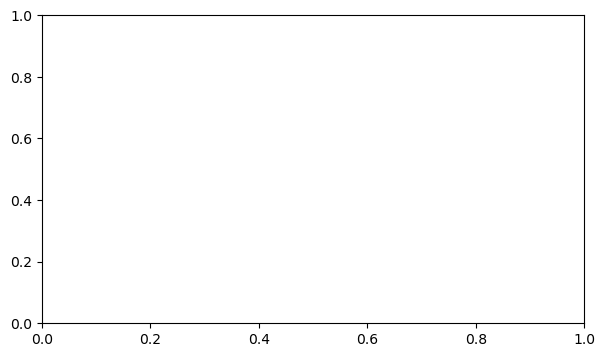

In [30]:
def basePlot(ax):
    mower_df.loc[mower_df.Ownership=='Owner'].plot(x='Income', y='Lot_Size', style='o', 
                                                   markerfacecolor='C0', markeredgecolor='C0',
                                                   ax=ax)
    mower_df.loc[mower_df.Ownership=='Nonowner'].plot(x='Income', y='Lot_Size', style='o',
                                                      markerfacecolor='none', markeredgecolor='C1',
                                                      ax=ax)
    ax.legend(["Owner", "Nonowner"]);
    ax.set_xlim(20, 120)
    ax.set_ylim(13, 25)
    ax.set_xlabel('Income ($000s)')
    ax.set_ylabel('Lot Size (000s sqft)')
    return ax

fig, ax = plt.subplots(figsize=(7, 4))

ax = basePlot(ax)
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))

ax = basePlot(ax)
x0 = 59.7
ax.plot((x0, x0), (25, 13), color='grey')
plt.tight_layout()
plt.show()

In [ ]:
classTree = DecisionTreeClassifier(random_state=0, max_depth=1)
classTree.fit(mower_df.drop(columns=['Ownership']), mower_df['Ownership'])
plotDecisionTree(classTree, feature_names=mower_df.columns[:2], class_names=classTree.classes_)

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))

ax = basePlot(ax)
x0 = 59.7
y1 = 21.4
ax.plot((x0, x0), (25, 13), color='grey')
ax.plot((20, x0), (y1, y1), color='grey')
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))

ax = basePlot(ax)
x0 = 59.7
y1 = 21.4
y2 = 19.8
ax.plot((x0, x0), (25, 13), color='grey')
ax.plot((20, x0), (y1, y1), color='grey')
ax.plot((x0, 120), (y2, y2), color='grey')
plt.tight_layout()
plt.show()

In [ ]:
classTree = DecisionTreeClassifier(random_state=0, max_depth=2)
classTree.fit(mower_df.drop(columns=['Ownership']), mower_df['Ownership'])
plotDecisionTree(classTree, feature_names=mower_df.columns[:2], class_names=classTree.classes_)

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))

ax = basePlot(ax)
x0 = 59.7
y1 = 21.4
y2 = 19.8
x3 = 84.75
x4 = 61.5
ax.plot((x0, x0), (25, 13), color='grey')
ax.plot((20, x0), (y1, y1), color='grey')
ax.plot((x0, 120), (y2, y2), color='grey')
ax.plot((x3, x3), (13, y2), color='grey')
ax.plot((x4, x4), (13, y2), color='grey')
plt.tight_layout()
plt.show()

In [ ]:
classTree = DecisionTreeClassifier(random_state=0)
classTree.fit(mower_df.drop(columns=['Ownership']), mower_df['Ownership'])
plotDecisionTree(classTree, feature_names=mower_df.columns[:2], class_names=classTree.classes_)

## Information about full decision tree

In [ ]:
tree = fullClassTree
print('Number of nodes', tree.tree_.node_count)

In [ ]:
estimator = tree
# Using those arrays, we can parse the tree structure:

n_nodes = estimator.tree_.node_count
children_left = estimator.tree_.children_left
children_right = estimator.tree_.children_right
feature = estimator.tree_.feature
threshold = estimator.tree_.threshold
value = estimator.tree_.value


# The tree structure can be traversed to compute various properties such
# as the depth of each node and whether or not it is a leaf.
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

from collections import Counter
nodeClassCounter = Counter()
terminal_leaves = 0
for i in range(n_nodes):
    if is_leaves[i]:
        terminal_leaves = terminal_leaves + 1
        nodeClassCounter.update([np.argmax(value[i][0])])
print()
print('Number of terminal leaves', terminal_leaves)
print(nodeClassCounter)

## Regression Trees : Table 9.7 and Figure 9.14

In [ ]:
toyotaCorolla_df = dmba.load_data('ToyotaCorolla.csv').iloc[:1000,:]
toyotaCorolla_df = toyotaCorolla_df.rename(columns={'Age_08_04': 'Age', 'Quarterly_Tax': 'Tax'})

predictors = ['Age', 'KM', 'Fuel_Type', 'HP', 'Met_Color', 'Automatic', 'CC', 
              'Doors', 'Tax', 'Weight']
outcome = 'Price'

X = pd.get_dummies(toyotaCorolla_df[predictors], drop_first=True)
y = toyotaCorolla_df[outcome]

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# user grid search to find optimized tree
param_grid = {
    'max_depth': [5, 10, 15, 20, 25], 
    'min_impurity_decrease': [0, 0.001, 0.005, 0.01], 
    'min_samples_split': [10, 20, 30, 40, 50], 
}
gridSearch = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Initial parameters: ', gridSearch.best_params_)

param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 
    'min_impurity_decrease': [0, 0.001, 0.002, 0.003, 0.005, 0.006, 0.007, 0.008], 
    'min_samples_split': [14, 15, 16, 18, 20, ], 
}
gridSearch = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Improved parameters: ', gridSearch.best_params_)

regTree = gridSearch.best_estimator_

In [ ]:
regressionSummary(train_y, regTree.predict(train_X))
regressionSummary(valid_y, regTree.predict(valid_X))

In [ ]:
plotDecisionTree(regTree, feature_names=train_X.columns)
plotDecisionTree(regTree, feature_names=train_X.columns, rotate=True)

## Figure 9.15 (no longer used)

In [ ]:
bank_df = dmba.load_data('UniversalBank.csv')
bank_df = bank_df.drop(columns=['ID', 'ZIP Code'])

X = bank_df.drop(columns=['Personal Loan'])
y = bank_df['Personal Loan']
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

rf = RandomForestClassifier(n_estimators=500, random_state=1)
rf.fit(train_X, train_y)

Variable importance plot

In [ ]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

df = pd.DataFrame({'feature': train_X.columns, 'importance': importances, 'std': std})
df = df.sort_values('importance')
print(df)

ax = df.plot(kind='barh', xerr='std', x='feature', legend=False)
ax.set_ylabel('')

plt.tight_layout()
plt.show()

Confusion matrix and metrics

In [ ]:
classificationSummary(valid_y, rf.predict(valid_X))

## Table 9.5

In [ ]:
boost = GradientBoostingClassifier()
boost.fit(train_X, train_y)
classificationSummary(valid_y, boost.predict(valid_X))